#<font color=skyblue>20165172 빅데이터 박한솔 기말 Project</font>

**기말 Project : fashion MNIST and scikit_learn**

** fashion MNIST 데이터 1000개만 가지고 학습, 평가(교차검중)함 : 아래 프로그램 참조
내용 : <p>
  1) 분류기 정확도(accuracy) 비교 : SVM, DecisionTree, RandomForestClassifier <p>
  2) 가장 좋은 분류기 성능 계산 : Confusion Matrix, Confusion Matrix error plot, Error Analysis <p>
  1) 목적 : Fashion MNIST 데이터를 가지고 ( SVM / DecisionTree / RandomForest ) <br>세 가지 모델을 파라미터 튜닝해서 각각의 최고성능(인식율)을 구한다. <p>
  2) 내용 및 방법 : 데이터 읽기 빛 분석, 모델 성능평가<p>
  3) 결과 : 각 분류기 성능 비교, 선택된 분류기로 결과 <p>



# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# fashion MNIST  

In [2]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, type(X_train), y_train.shape, type(y_train)

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), numpy.ndarray, (60000,), numpy.ndarray)

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
y_test.shape

(10000,)

### 데이터를 1차원으로 reshape
### 속도를 빠르게 하기위해 데이터 1000개만 사용
### 이 데이터로 학습하고, 교차검증하기

In [7]:
X = X_train[:1000].reshape(-1, 784)  
y = y_train[:1000]

In [ ]:
X.shape

(1000, 784)

In [ ]:
y.shape 

(1000,)

In [8]:
X_test = X_test[:1000].reshape(-1,784)
y_test = y_test[:1000]

In [ ]:
X_test.shape

(1000, 784)

In [ ]:
y_test.shape

(1000,)

In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names[9]

'Ankle boot'

Text(0.5, 1.0, 'Ankle boot')

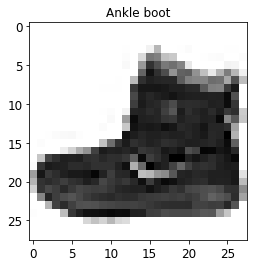

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

idx = 0
some_digit = X[idx]
some_digit_image = some_digit.reshape(28,28)
some_digit_label = y[idx]
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.title(class_names[some_digit_label])

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

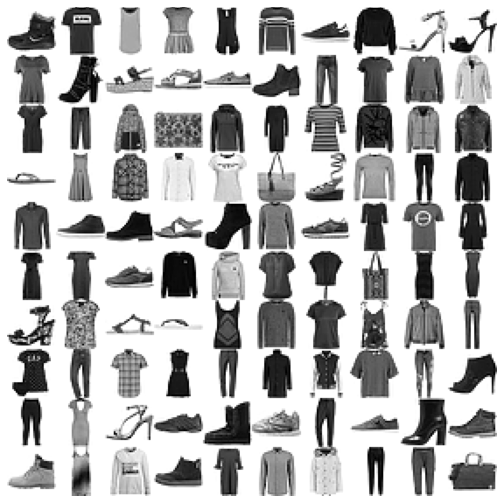

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

# 1) 분류기 정확도(accuracy) 비교 : SVM, DecisionTree, RandomForest

* 전처리 : Standard Scaler

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

In [12]:
X_scaled, X_test_scaled

(array([[ 0.        , -0.04246464, -0.03943542, ..., -0.14037804,
         -0.08883466, -0.03712832],
        [ 0.        , -0.04246464, -0.03943542, ..., -0.14037804,
         -0.08883466, -0.03712832],
        [ 0.        , -0.04246464, -0.03943542, ..., -0.14037804,
         -0.08883466, -0.03712832],
        ...,
        [ 0.        , -0.04246464, -0.03943542, ..., -0.14037804,
         -0.08883466, -0.03712832],
        [ 0.        , -0.04246464, -0.03943542, ..., -0.14037804,
         -0.08883466, -0.03712832],
        [ 0.        , -0.04246464, -0.03943542, ..., -0.14037804,
         -0.08883466, -0.03712832]]),
 array([[ 0.        , -0.04836104, -0.08117007, ..., -0.15706119,
         -0.09009898, -0.04460118],
        [ 0.        , -0.04836104, -0.08117007, ..., -0.15706119,
         -0.09009898, -0.04460118],
        [ 0.        , -0.04836104, -0.08117007, ..., -0.15706119,
         -0.09009898, -0.04460118],
        ...,
        [ 0.        , -0.04836104, -0.08117007, ..., 1

##SVM (SVC)

###SVM Default

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [15]:
svc_clf = SVC()
svc_clf.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

* Train Score

In [16]:
svc_train_cv_score = cross_val_score(svc_clf, X, y, cv=3, scoring="accuracy")
svc_train_score1 = np.average(svc_train_cv_score) # train
svc_train_score1

0.8070225914537291

* Test Score

In [19]:
y_pred = svc_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.786

X Scaled

In [28]:
svc_clf2 = SVC()
svc_clf2.fit(X_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
svc_train_cv_score1 = cross_val_score(svc_clf2, X_scaled, y, cv=3, scoring="accuracy")
svc_train_score1 = np.average(svc_train_cv_score1) # train
svc_train_score1 

0.7960145774517032

In [73]:
y_pred = svc_clf2.predict(X_test_scaled)
svc_test_score1 = accuracy_score(y_test, y_pred)
svc_test_score1

0.783

### SVM 다항 커널 (Poly)

In [34]:
from sklearn.pipeline import Pipeline

In [ ]:
max_score = 0

for coef in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    poly_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("svc_clf", SVC(kernel="poly", C=C, coef0=coef, random_state=42)) 
    ])
    scores = cross_val_score(poly_clf, X, y, cv=3)
    score = np.mean(scores)

    if score > max_score:
      max_score = score
      best_coef = coef
      best_C = C

In [ ]:
max_score, best_coef, best_C

(0.8269946593299887, 1, 1)

In [36]:
poly_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("svc_clf", SVC(kernel="poly", C=best_C, coef0=best_coef ,random_state=42)) 
    ])
poly_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc_clf',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [37]:
svc_train_cv_score2 = cross_val_score(poly_clf, X, y, cv=3, scoring="accuracy")
svc_train_score2 = np.average(svc_train_cv_score2)
svc_train_score2 

0.8269946593299887

In [72]:
y_pred = poly_clf.predict(X_test)
svc_test_score2 = accuracy_score(y_test, y_pred)
svc_test_score2

0.815

### SVM 가우시안 커널 (Rbf)

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
max_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    rbf_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("svc_clf", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42)) 
    ])
    scores = cross_val_score(rbf_clf, X, y, cv=3)
    score = np.mean(scores)

    if score > max_score:
      max_score = score
      best_gamma = gamma
      best_C = C

In [ ]:
max_score,  best_gamma, best_C

(0.8140056223888559, 0.001, 10)

In [102]:
best_gamma = 0.001
best_C=8

In [88]:
rbf_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("svc_clf", SVC(kernel="rbf", gamma=best_gamma, C=best_C, random_state=42)) # gamma= scaled
])
rbf_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc_clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
                     random_state=38, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [103]:
rbf_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("svc_clf", SVC(kernel="rbf", gamma=best_gamma, C=best_C, random_state=42)) # gamma= scaled
])
rbf_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc_clf',
                 SVC(C=8, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [104]:
svc_train_cv_score3 = cross_val_score(rbf_clf, X, y, cv=3, scoring="accuracy")
svc_train_score3 = np.mean(svc_train_cv_score3)
svc_train_score3

0.8160016303728878

In [140]:
y_pred = rbf_clf.predict(X_test)
svc_test_score3 = accuracy_score(y_test, y_pred)
svc_test_score3

0.814

### SVM 시그모이드 커널 (Sigmoid)

In [ ]:
max_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    for coef in [0.001, 0.01, 0, 0.1, 1, 10, 100]:
      sig_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("sig_clf", SVC(kernel="sigmoid", C=C, gamma=gamma, coef0 = coef , random_state=42)) 
      ])
      scores = cross_val_score(sig_clf, X, y, cv=3)
      score = np.mean(scores)

      if score > max_score:
        max_score = score
        best_gamma = gamma
        best_C = C
        best_coef = coef

In [ ]:
max_score, best_C, best_gamma, best_coef

(0.7960145774517032, 1, 0.001, 0.01)

In [66]:
 sig_clf = Pipeline([
                     ("scaler", StandardScaler()),
                     ("sig_clf", SVC(kernel="sigmoid", C=best_C, gamma=best_gamma, coef0 = best_coef , random_state=42)) 
  ])
 sig_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sig_clf',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.01, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='sigmoid', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [67]:
svc_train_cvs_score4 = cross_val_score(sig_clf, X, y, cv=3, scoring="accuracy")
svc_train_score4 = np.average(svc_train_cvs_score4)
svc_train_score4

0.7960145774517032

In [69]:
y_pred = sig_clf.predict(X_test)
svc_test_score4 = accuracy_score(y_test, y_pred)
svc_test_score4

0.778

###Best Score of SVM - 다항 커널 (Polynomial)

In [141]:
svc_test_score = max(svc_test_score1,svc_test_score2,svc_test_score3, svc_test_score4)
svc_test_score

0.815

Best SVC : Polynomial Kernel (0.801)

##DecisionTree

### DT default

In [106]:
from sklearn.tree import DecisionTreeClassifier

In [107]:
dtc_clf = DecisionTreeClassifier() 
dtc_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [108]:
scores = cross_val_score(dtc_clf, X, y, cv=3)
score = np.mean(scores)
score

0.6970203736670803

In [110]:
y_pred = dtc_clf.predict(X_test)
dtc_test_score = accuracy_score(y_test, y_pred)
dtc_test_score

0.677

###DT grid search

In [ ]:
max_score = 0

for depth in [1,3,5,7,9,11]:
  for leaf in [1,3,5,7,9,11]:
    dtc_clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf = leaf, random_state=42)

    scores = cross_val_score(dtc_clf, X, y, cv=3)
    score = np.mean(scores)

    if score > max_score:
      max_score = score
      best_depth = depth
      best_leaf = leaf

In [ ]:
max_score, best_depth, best_leaf

(0.6930133726540912, 7, 1)

In [117]:
 dtc_clf = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf = best_leaf, random_state=42)
 dtc_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [121]:
dt_train_cvs = cross_val_score(dtc_clf, X, y, cv=3, scoring="accuracy")
dt_train_score = np.average(dt_train_cvs)
dt_train_score

0.7020343696990402

In [122]:
y_pred = dtc_clf.predict(X_test)
dtc_test_score = accuracy_score(y_test, y_pred)
dtc_test_score

0.695

Tree 시각화

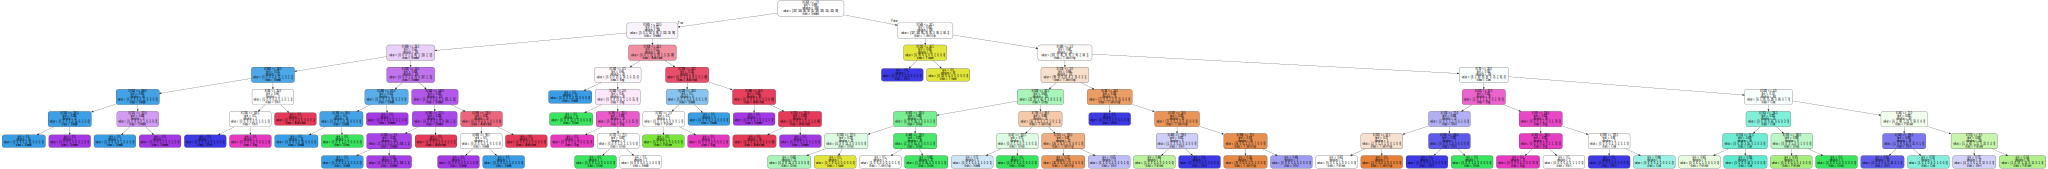

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(dtc_clf, out_file="dt.dot", class_names= class_names, rounded=True, filled=True)

import graphviz
with open("dt.dot") as d:
  dot_graph = d.read()
graphviz.Source(dot_graph)

In [ ]:
graphviz.Source(dot_graph).render(filename="dt.png") #png로 저장

'dt.png.pdf'

##Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
max_score = 0

for depth in range(10,20):
  for estimators in [300, 500, 1000, 1500, 2000, 2500]:
    rfc_clf = RandomForestClassifier(max_depth=depth, n_estimators = estimators, random_state=42)

    scores = cross_val_score(rfc_clf, X, y, cv=3)
    score = np.mean(scores)

    if score > max_score:
      max_score = score
      best_depth = depth
      best_estimators = estimators

In [ ]:
max_score, best_depth, best_estimators

(0.8289996583409757, 13, 2000)

In [124]:
best_depth = 13
best_estimators = 2000

In [125]:
rfc_clf = RandomForestClassifier(max_depth=best_depth, n_estimators=best_estimators, random_state=42)
rfc_clf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [137]:
rfc_clf = RandomForestClassifier(max_depth=best_depth, n_estimators=best_estimators, random_state=52)
rfc_clf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=52, verbose=0,
                       warm_start=False)

In [127]:
rfc_train_cvs = cross_val_score(rfc_clf, X, y, cv=3, scoring="accuracy")
rfc_train_score = np.average(rfc_train_cvs) # accuracy average
rfc_train_score

0.8289996583409757

In [139]:
y_pred = rfc_clf.predict(X_test)
rfc_test_score = accuracy_score(y_test, y_pred)
rfc_test_score

0.818

predict

##SVM, DecisionTree, RandomForest 정확도 비교


In [145]:
# 정확도 표
import pandas as pd
pd.DataFrame(data = [svc_test_score, dtc_test_score, rfc_test_score], index=["SVC","DecisionTree","RandomForest"], columns=["Accuracy"])

,Accuracy
SVC,0.815
DecisionTree,0.695
RandomForest,0.818


RandomForest의 Accuracy가 0.818 으로 가장 높음을 알 수 있다.

# 2) 가장 좋은 분류기 성능 계산 : Confusion Matrix, Confusion Matrix error plot, Error Analysis

##RandomForest 평가

##Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [ ]:
y_test_pred = cross_val_predict(rfc_clf, X_test, y_test, cv=3)
conf_mx = confusion_matrix(y_test,y_test_pred)
conf_mx

array([[88,  0,  3, 10,  0,  0,  3,  0,  3,  0],
       [ 1, 98,  1,  5,  0,  0,  0,  0,  0,  0],
       [ 2,  0, 81,  2, 20,  0,  6,  0,  0,  0],
       [ 4,  2,  1, 77,  5,  0,  3,  0,  1,  0],
       [ 0,  1, 16,  8, 82,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 71,  0,  7,  1,  8],
       [18,  0, 19,  5, 18,  0, 35,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  6,  0, 81,  0,  8],
       [ 0,  1,  0,  1,  3,  1,  0,  0, 89,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  6,  0, 85]])

##Confusion Matrix error plot

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

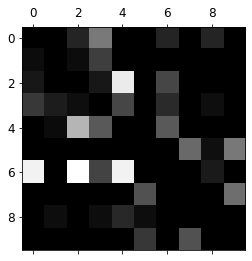

In [ ]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

분석 : 2를 4로, 6을 2로 오인식하고 있다. (가장 오인식률이 높은 것 : 2->4)<br>

2 : Pullover<br>
4 : Coat <br>
6 : Shirt


#인식결과

그림 저장: error_analysis_digits_plot


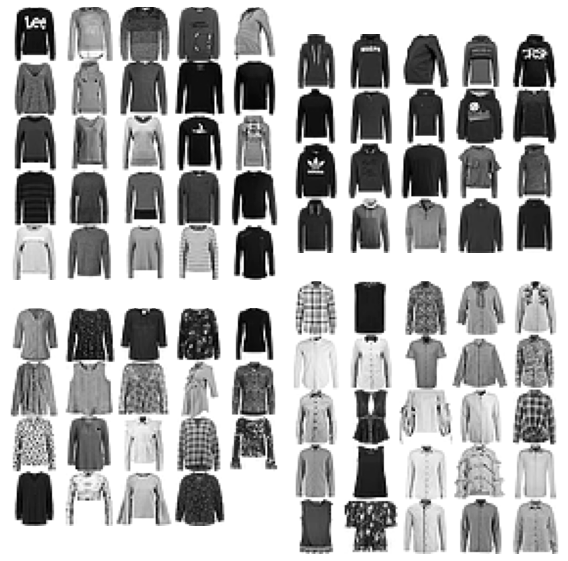

In [ ]:
X_aa = X_test[(y_test == 2) & (y_test_pred == 2)] # 2 -> 2
X_ab = X_test[(y_test == 2) & (y_test_pred == 4)] # 2 -> 4
X_cd = X_test[(y_test == 6) & (y_test_pred == 2)] # 6 -> 2
X_cc = X_test[(y_test == 6) & (y_test_pred == 6)] # 6 -> 6

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_cd[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_cc[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

###특징의 중요도 시각화

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

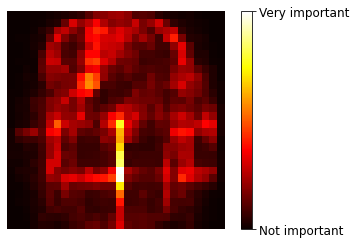

In [ ]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")
    
plot_digit(rfc_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rfc_clf.feature_importances_.min(),rfc_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

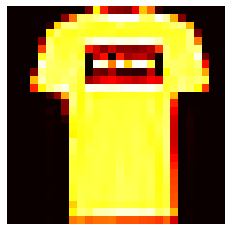

In [ ]:
plot_digit(X[1])

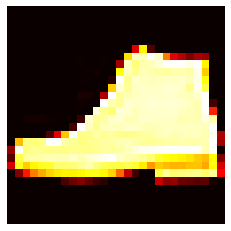

In [ ]:
 plot_digit(X[42])